In [1]:
import numpy as np
import statistics
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
import scipy.stats
import ipywidgets as widgets
import pandas as pd
from datetime import datetime
import mysql.connector
import matplotlib.pyplot as plt


In [72]:
fields = ['T_GEN_1','T_GEN_2','T_BEAR_A','T_BEAR_B','T_GEAR','T_AMB','T_NAC','T_GEN_COOL','T_GEAR_BEAR','T_BEAR_SHAFT','OS','STATE_FAULT','I_A','I_B','I_C']
mydb = mysql.connector.connect(
  host="techlokdb.tk.informatik.tu-darmstadt.de",
  user="mo",
  passwd="DiedP20!8",
  database="swc"
)
window_width = 28 # 28 is the average number of data points collected in an hour for each device
plt.tight_layout()
plt.rcParams["figure.figsize"] = (20,10)

<Figure size 1440x720 with 0 Axes>

In [8]:
def convertFields2String(fields):
    if len(fields) == 1:
        return fields[0]
    else:
        return ' ,'.join(fields)
        
def getDataFromDB(startDate,EndDate,fields):
    mycursor = mydb.cursor()
    mycursor.execute("""SELECT builtin_captured, {}   FROM gewe_data_155x 
    WHERE builtin_number = 'GE-1540-0423' 
    and builtin_captured >= '{}' AND builtin_captured <='{}' ORDER BY builtin_captured""".format(convertFields2String(fields),startDate,EndDate))
    myresult = mycursor.fetchall()
    return myresult

In [80]:
myresult = getDataFromDB('2018-01-01','2018-01-10',fields)

In [83]:
values = [(row[4],row[10]) for row in myresult]
np_array = np.array(values)
x,y=np_array.transpose()
print(np_array.shape)

(25915, 2)


In [87]:
np.cov(x,y)

array([[187.66018832,  43.25167623],
       [ 43.25167623,  12.56306044]])

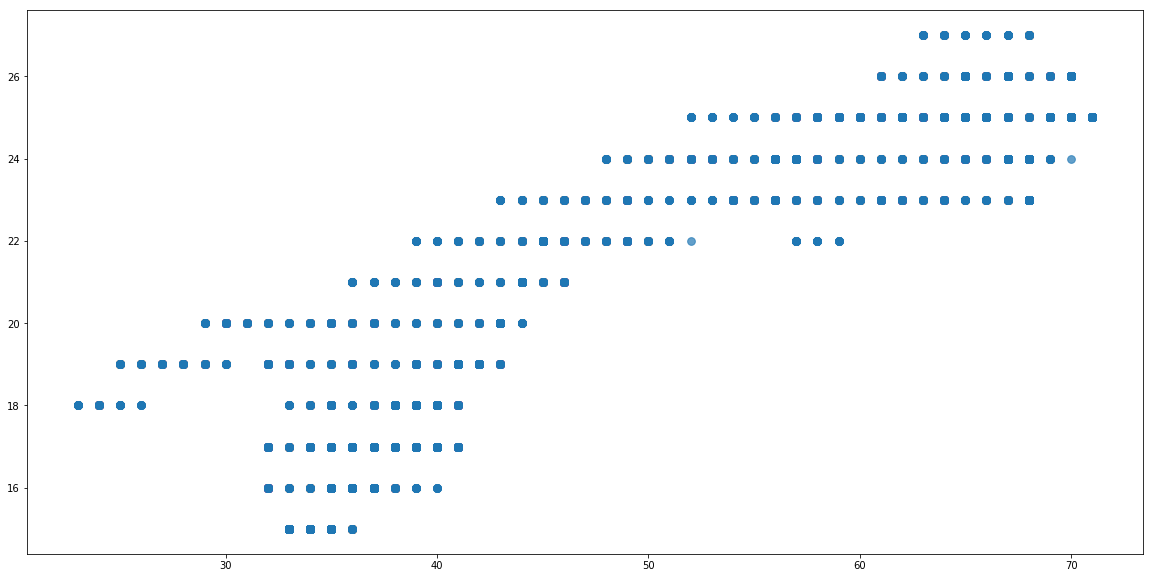

In [86]:
plt.scatter(x,y, s=60, zorder=10, alpha=0.7)
plt.show()

In [88]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False 

In [91]:
covariance_matrix = np.cov(x,y, rowvar=False)  

In [92]:
covariance_matrix

array([[187.66018832,  43.25167623],
       [ 43.25167623,  12.56306044]])

In [93]:
is_pos_def(covariance_matrix)

True

In [101]:
data = np_array

In [102]:
vars_mean = []
for i in range(data.shape[0]):
    vars_mean.append(list(data.mean(axis=0)))

In [104]:
np.mean(x)

49.20582674126953

data:
 [[ 15   8]
 [ 10   5]
 [ 10  12]
 [ 13  12]
 [  9  11]
 [ 14   9]
 [ 11  12]
 [ 15  14]
 [ 11  13]
 [ 10   4]
 [  7  13]
 [  7  13]
 [  6  11]
 [ 80  87]
 [ 89 100]]

Covariance Matrix:
 [[686.40952381 762.34285714]
 [762.34285714 866.68571429]]

Inverse of Covariance Matrix:
 [[ 0.06310192 -0.05550489]
 [-0.05550489  0.04997632]]

Variables Mean Vector:
 [[20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6], [20.466666666666665, 21.6]]

Variables - Variables Mean Vector:
 [[ -5.46666667 -13.6       ]
 [-10.46666667 -16.6       ]
 [-10.46666667  -9.6       ]
 [ -7.46666667  -9.6       ]
 [-11.46666667 -10.6       ]
 [ -6.46666667 -12.6       ]
 [ 

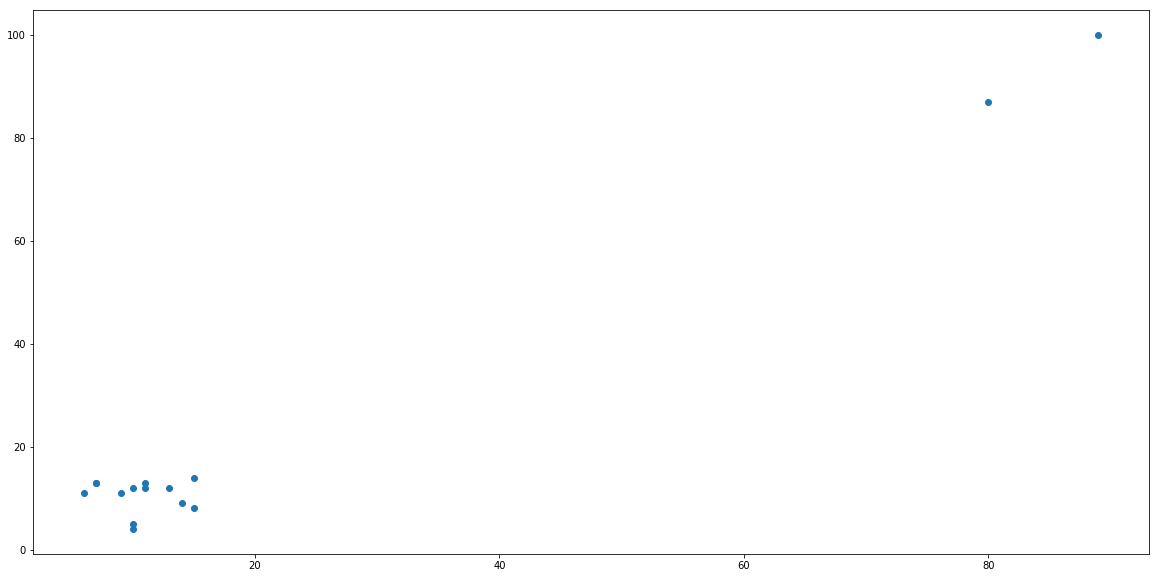

In [138]:
import numpy as np


def create_data(examples=50, features=5, upper_bound=10, outliers_fraction=0.1, extreme=False):
    '''
    This method for testing (i.e. to generate a 2D array of data)
    '''
    data = []
    magnitude = 3 if extreme else 2
    for i in range(examples):
        if (examples - i) <= round((float(examples) * outliers_fraction)):
            data.append(np.random.poisson(upper_bound ** magnitude, features).tolist())
        else:
            data.append(np.random.poisson(upper_bound, features).tolist())
    return np.array(data)


def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    std = np.std(data)
    k = 3.*std if extreme else 1.5*std
    up_t = np.mean(data) + k
    low_t = np.mean(data) - k
    outliers = []
    for i in range(len(MD)):
        print('MD[i]:',MD[i],' - up_t:',up_t,' - low_t:',low_t)
        if (MD[i] > up_t) or (MD[i] < low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False


data = create_data(15, 2, 10, 0.1)
print("data:\n {}\n".format(data))

outliers_indices = MD_detectOutliers(data, verbose=True)

print("Outliers Indices: {}\n".format(outliers_indices))
print("Outliers:")
for ii in outliers_indices:
    print(data[ii])
plt.scatter(data[:,0],data[:,1])

In [136]:
np.std(data[:,0])

31.645255919682846

In [137]:
np.mean(data[:,0])

22.666666666666668

In [106]:
data

array([[  6,  12,  14],
       [ 10,  12,   5],
       [ 13,  13,   7],
       [  8,   9,   9],
       [  9,  10,  13],
       [ 11,  12,  12],
       [  5,  12,  12],
       [ 10,  15,  12],
       [  9,  12,   8],
       [ 10,  10,   5],
       [ 10,   9,   9],
       [ 13,  11,  14],
       [ 10,  10,   6],
       [ 84,  97, 118],
       [114, 124,  95]])

In [110]:
data.ndim

2

In [118]:
np.mean(data,axis=0)
std = np.std(data,axis = 0)
k = 3.*std 
up_t = np.mean(data,axis =0) + k
low_t = np.mean(data,axis =0) - k
print(up_t,low_t)

[110.89726253 130.13179616 112.77423218] [-68.09726253 -80.93179616 -70.37423218]


In [112]:
data[:,0]

array([  6,  10,  13,   8,   9,  11,   5,  10,   9,  10,  10,  13,  10,
        84, 114])